Имя на Kaggle: OlesyaPetrova

Public Score: 0.85357

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, QuantileTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
import xgboost
from catboost import CatBoostClassifier
import catboost
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
X_test = pd.read_csv('test.csv')
X_test['TotalSpent'] = pd.to_numeric(X_test['TotalSpent'], errors='coerce')

In [3]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

# Overview

In [4]:
data = pd.read_csv('train.csv')

In [5]:
data[num_cols].sample(8)

,ClientPeriod,MonthlySpending,TotalSpent
1158,3,91.50,242.95
2065,25,95.90,2448.75
3557,23,44.95,996.85
3988,22,20.05,417
71,12,20.05,265.45
159,21,20.85,435.25
1861,51,81.15,4126.2
3411,12,35.50,432.25


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [7]:
data.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

## Clean Data

### Missing values

In [8]:
data[pd.to_numeric(data['TotalSpent'], errors='coerce').isnull()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [9]:
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')

In [10]:
data.isna().sum().sort_values(ascending = False)

TotalSpent                  9
ClientPeriod                0
HasOnlineBackup             0
PaymentMethod               0
IsBillingPaperless          0
HasContractPhone            0
HasMovieSubscription        0
HasOnlineTV                 0
HasTechSupportAccess        0
HasDeviceProtection         0
HasOnlineSecurityService    0
MonthlySpending             0
HasInternetService          0
HasMultiplePhoneNumbers     0
HasPhoneService             0
HasChild                    0
HasPartner                  0
IsSeniorCitizen             0
Sex                         0
Churn                       0
dtype: int64

Так как во всех случаях `ClientPeriod` = 0, предположим что `TotalSpent` = 0

In [11]:
data['TotalSpent'].fillna(0, inplace = True)

In [12]:
data['TotalSpent'] = data['TotalSpent'].astype('float');

### Duplicates

In [13]:
data.duplicated().sum()

14

In [14]:
data.drop_duplicates(inplace = True)

# Data analysis

#### Numerical features

Построим гистограму и boxplot для каждого числового признака

In [16]:
for row in num_cols:
    size = len(data[row].value_counts()) 
    if size >= 1000:
        size = 200
    fig = px.histogram(data,x=row, color='Churn', marginal='box', template="simple_white", nbins = size, width = 800)
    
    fig.show()

1. `ClientPeriod` - большинство лояльных клиентов сотрудничают с компанией меньше 29 месяцев, отток клиентов происходит почти равномерно по всему периоду, за исключением 1 и 71-72 месяцев
*  `Churn` = 1 - 25% = 1, 75% = 29
*  `Churn` = 0 - 25% = 15, 75% = 61
2. `MonthlySpending` - большое количество клиентов использующих самый дешевый тариф отказываются от услуг компании, лояльные клиенты предпочитают более дорогие тарифы
*  `Churn` = 1 - 25% = 56.65, 75% = 94.25
*  `Churn` = 0 - 25% = 25.1, 75% = 89.15
3. `TotalSpent`
*  `Churn` = 1 - 25% = 141.6, 75% = 2362.1
*  `Churn` = 0 - 25% = 565.75, 75% = 4282.4

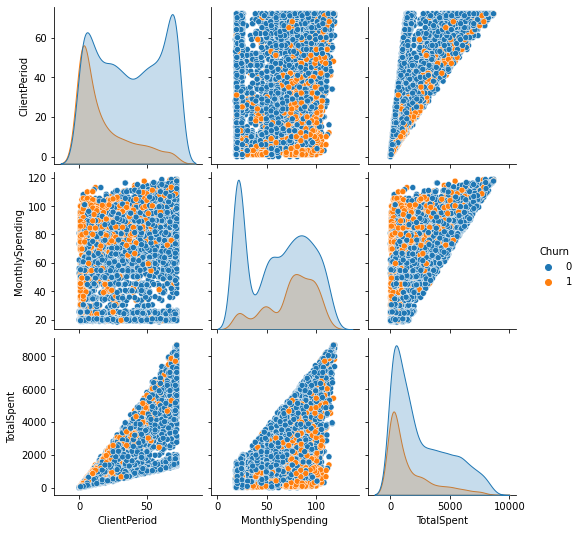

In [17]:
sns.pairplot(data[num_cols + [target_col]], vars=num_cols, hue=target_col)

#### Categorical features

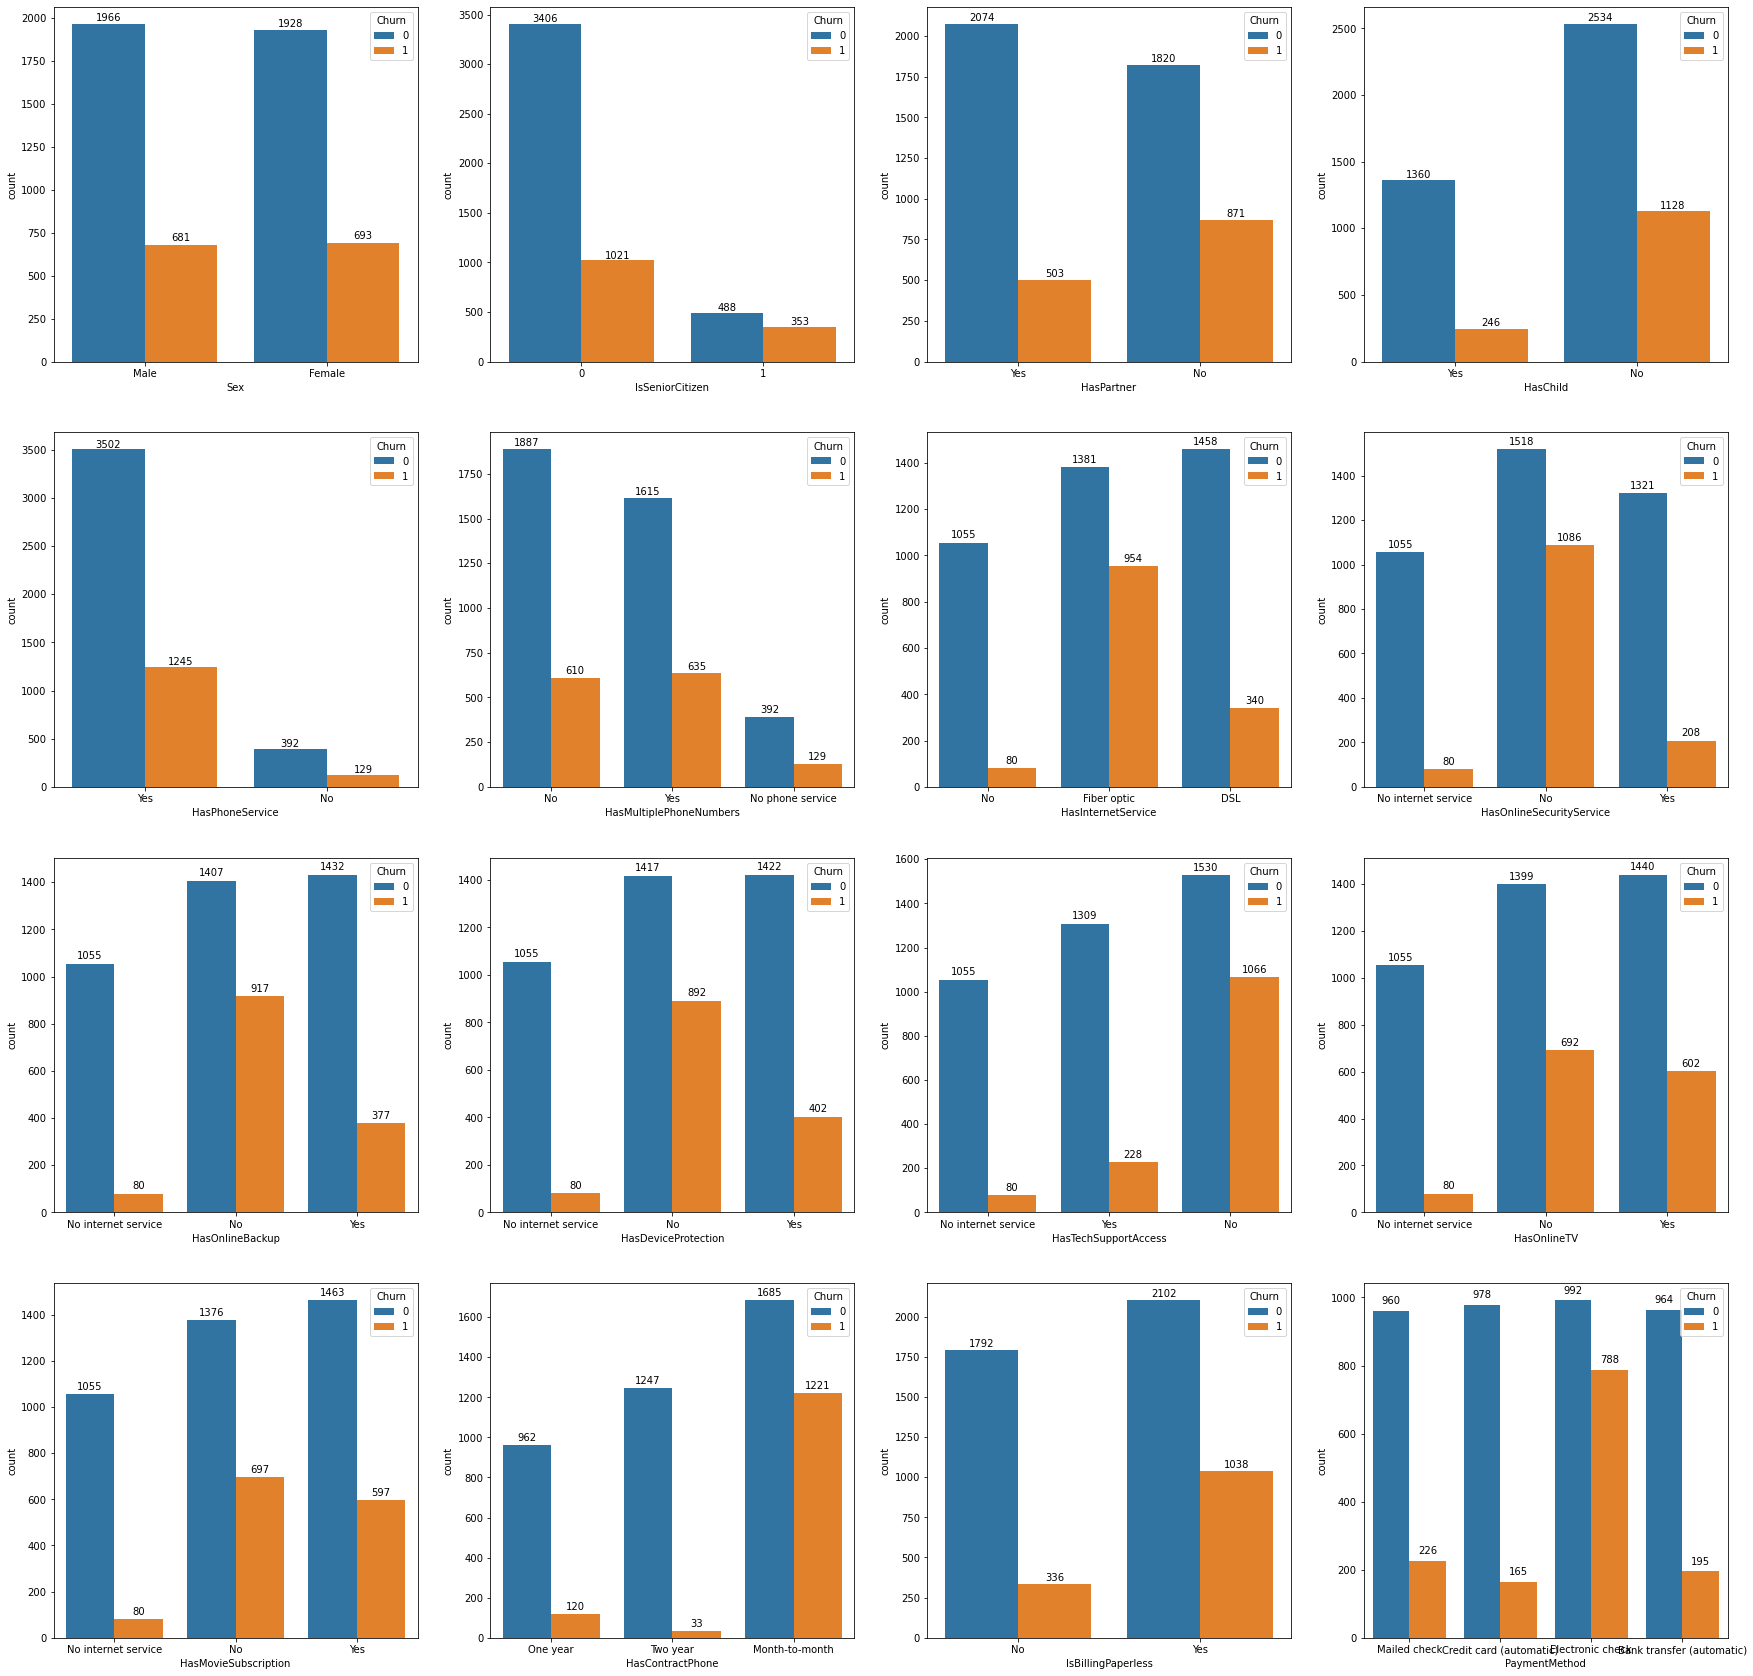

In [18]:
f, axs = plt.subplots(4, 4, figsize=(30, 30))
for i, col in enumerate(cat_cols):
    ax1 = sns.countplot(x=col, data=data, hue = 'Churn', ax=axs.reshape(-1)[i])
    for p in ax1.patches:
            height = p.get_height()
            ax1.text(p.get_x()+p.get_width()/2., height + 20,'{:1.0f}'.format(height), ha="center")

#### Target

In [19]:
fig = px.histogram(data,x = target_col,   template="simple_white", color = 'Churn', width = 600)
fig.update_xaxes(type='category')
fig.show()

Распределение целевой переменной не идеально сбалансированно.

<AxesSubplot:>

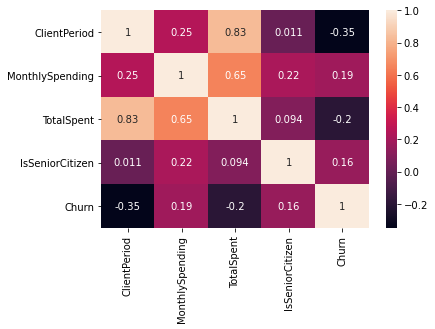

In [20]:
sns.heatmap(data.corr(), annot = True)

Между некоторыми признаками имеется довольно сильная корреляция.

# Model

In [21]:
roc_auc = pd.DataFrame(columns = ['roc_auc'])

In [22]:
X_train = data[num_cols + cat_cols].copy()
y_train = data[target_col].copy()

In [23]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                         ('qtr', QuantileTransformer())])
cat_pipeline = Pipeline([('ohe', OneHotEncoder(drop='if_binary'))])

trf = ColumnTransformer([('num_cols', num_pipeline, num_cols),
                         ('cat_cols', cat_pipeline, cat_cols)])


### LogisticRegression

In [24]:
lr = Pipeline([('trf', trf), ('lr', LogisticRegression(random_state=13))])

lr_g = GridSearchCV(lr, {'lr__C': [100, 10, 1, 0.1, 0.01, 0.001]}, scoring='roc_auc')

In [25]:
lr_g.fit(X_train, y_train);
lr_g.best_params_

{'lr__C': 1}

In [26]:
lr_g_auc = roc_auc_score(y_train, lr_g.predict_proba(X_train)[:, 1])
roc_auc = roc_auc.append(pd.Series({'roc_auc':lr_g_auc}, name='LogisticRegression_grid'), ignore_index = False)

### Decision Tree

In [27]:
#clf = Pipeline([('trf', trf), ('clf', DecisionTreeClassifier(random_state=13))])
#clf_g = GridSearchCV(clf, {'clf__ccp_alpha': [0.1, 0.01, 0.001, 0.005],
#                           'clf__max_depth': [2, 4, 5, 7],
#                           'clf__min_samples_split': [2, 4, 5, 7]}, scoring='roc_auc')
#
#clf_g.fit(X_train, y_train);

In [28]:
#clf_g.best_params_
#{'clf__ccp_alpha': 0.001, 'clf__max_depth': 5, 'clf__min_samples_split': 2}

In [29]:
clf_g = Pipeline([('trf', trf), ('clf', DecisionTreeClassifier(random_state=13,  ccp_alpha = 0.001, max_depth = 5, min_samples_split = 2))])
clf_g.fit(X_train, y_train);

In [30]:
clf_g_auc = roc_auc_score(y_train, clf_g.predict_proba(X_train)[:, 1])
roc_auc = roc_auc.append(pd.Series({'roc_auc':clf_g_auc}, name='Decision Tree_grid'), ignore_index = False)

### Random Forest

In [31]:
#clf_rf = Pipeline([('trf', trf), ('clf_rf', RandomForestClassifier(random_state=13))])
#clf_rf_g = GridSearchCV(clf_rf, {'clf_rf__n_estimators': [100,1000, 100],
#                                 'clf_rf__max_depth': [2, 4, 5, 7],
#                                 'clf_rf__min_samples_split': [2, 4, 5, 7]}, scoring='roc_auc')
#clf_rf_g.fit(X_train, y_train);

In [32]:
#clf_rf_g.best_params_
#{'clf_rf__max_depth': 7,
# 'clf_rf__min_samples_split': 7,
# 'clf_rf__n_estimators': 1000}

In [33]:
clf_rf_g = Pipeline([('trf', trf), ('clf_rf', RandomForestClassifier(random_state=13, max_depth = 7, min_samples_split = 7, n_estimators = 1000))])
clf_rf_g.fit(X_train, y_train);

In [34]:
clf_rf_g_auc = roc_auc_score(y_train, clf_rf_g.predict_proba(X_train)[:, 1])
roc_auc = roc_auc.append(pd.Series({'roc_auc':clf_rf_g_auc}, name='Random Forest_grid'), ignore_index = False)

### Xgboost

In [35]:
X_train_, X_valid, y_train_, y_valid = train_test_split(X_train, y_train, random_state=13)

In [36]:
Xgb_default = Pipeline([('trf', trf), ('xgb', xgboost.XGBClassifier(random_seed=13))])
Xgb_default.fit(X_train_, y_train_);

[15:43:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "random_seed" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:43:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [37]:
Xgb_default_auc = roc_auc_score(y_valid, Xgb_default.predict_proba(X_valid)[:, 1])
roc_auc = roc_auc.append(pd.Series({'roc_auc':Xgb_default_auc}, name='XGB_def'), ignore_index = False)

### CatBoost

In [38]:
c_default = CatBoostClassifier(cat_features=cat_cols, random_seed=13, verbose=False)
c_default.fit(X_train_, y_train_)

In [39]:
c_default_auc = roc_auc_score(y_valid, c_default.predict_proba(X_valid)[:, 1])
roc_auc = roc_auc.append(pd.Series(data={'roc_auc':c_default_auc}, name='CatBoost_def'))

In [40]:
catboost_param_grid = {'iterations':[500, 1000, 1500],
                         'depth':[1, 2, 3, 4, 5],
                         'l2_leaf_reg':[1, 3, 5, 10, 20, 30]}
c_grid = CatBoostClassifier(cat_features=cat_cols, random_seed=42, verbose=False)
c_grid.grid_search(catboost_param_grid, X_train, y=y_train, verbose=False)


bestTest = 0.3960397959
bestIteration = 499


bestTest = 0.3962838669
bestIteration = 499


bestTest = 0.3966861277
bestIteration = 498


bestTest = 0.3962361738
bestIteration = 499


bestTest = 0.3968729391
bestIteration = 496


bestTest = 0.3969407994
bestIteration = 498


bestTest = 0.3948384333
bestIteration = 832


bestTest = 0.3951308505
bestIteration = 992


bestTest = 0.395488907
bestIteration = 770


bestTest = 0.3949670647
bestIteration = 999


bestTest = 0.3953737382
bestIteration = 995


bestTest = 0.3957947514
bestIteration = 995


bestTest = 0.3948384333
bestIteration = 832


bestTest = 0.3951308505
bestIteration = 992


bestTest = 0.395488907
bestIteration = 770


bestTest = 0.3948878131
bestIteration = 1093


bestTest = 0.395351242
bestIteration = 1008


bestTest = 0.3955243325
bestIteration = 1326


bestTest = 0.3956311543
bestIteration = 495


bestTest = 0.3954406735
bestIteration = 495


bestTest = 0.3957081734
bestIteration = 499


bestTest = 0.3951091796
bestItera

{'params': {'depth': 5, 'l2_leaf_reg': 5, 'iterations': 500},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
        

In [41]:
c_grid_auc = roc_auc_score(y_valid, c_grid.predict_proba(X_valid)[:, 1])
roc_auc = roc_auc.append(pd.Series(data={'roc_auc':c_grid_auc}, name='CatBoost_grid'))

# Submission

In [42]:
roc_auc

,roc_auc
LogisticRegression_grid,0.850171
Decision Tree_grid,0.838131
Random Forest_grid,0.885403
XGB_def,0.818204
CatBoost_def,0.832305
CatBoost_grid,0.860165


In [43]:
best_model = c_grid

In [44]:
output = pd.DataFrame({'Id': X_test.index, 'Churn': best_model.predict_proba(X_test[num_cols + cat_cols])[:, 1]})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
